In [7]:
import cv2
import numpy as np
from pathlib import Path
from scipy import ndimage
from skimage import measure, color, io
import openslide
from PIL import Image
from sklearn.cluster import KMeans
import json

In [8]:
# rotation, flip
def flip(img, flag):
    return cv2.flip(flag) # 0 -> vertical; 1 -> horizontal

def rotate(img, theta):
    angle = int(random.uniform(-theta, theta))
    h,w = img.shape[:2]
    M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
    img = cv2.warpAffine(img, M, (w, h))
    return img

# brightness
def brightness(img, low=0.2, high=2):
    value = random.uniform(low, high)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv = np.array(hsv, dtype = np.float64)
    hsv[:,:,1] = hsv[:,:,1]*value
    hsv[:,:,1][hsv[:,:,1]>255]  = 255
    hsv[:,:,2] = hsv[:,:,2]*value 
    hsv[:,:,2][hsv[:,:,2]>255]  = 255
    hsv = np.array(hsv, dtype = np.uint8)
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return img

# sharpen
def sharpen(img):
    kernel = np.array([[0, -1, 0],
                       [-1, 5,-1],
                       [0, -1, 0]])
    image_sharp = cv2.filter2D(src=im, ddepth=-1, kernel=kernel)
    return image_sharp

def blur(img, sig_x=0, sig_y=0):
    blur = cv2.GaussianBlur(im,(5,5),sig_x, sig_y)
    return blur

In [9]:
# morphology operation
from skimage.color import rgb2hed
from skimage.filters import threshold_otsu # seperate background & foreground
from skimage.morphology import closing, opening, disk
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.segmentation import clear_border

def waterShed(file_name, kernel_size=3, perc=0.2):
    im = cv2.imread(file_name)
    cells = im[:, :, 0]
    hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
    cells = hsv[:, :, 1]
    ret1, thresh = cv2.threshold(cells, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    opening = clear_border(opening)
    #plt.imshow(opening, cmap='gray')
    sure_bg = cv2.dilate(opening, kernel, iterations=5)
    plt.imshow(sure_bg, cmap='gray')
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
#     plt.imshow(dist_transform, cmap='gray')
#     plt.show()
# #     print(dist_transform.max())
    
#     ret2, sure_fg = cv2.threshold(dist_transform, perc*dist_transform.max(), 255, 0)
#     plt.imshow(sure_fg, cmap='gray')
    
#     sure_fg = np.uint8(sure_fg)
#     sure_bg = np.uint8(sure_bg)
#     unknown = cv2.subtract(sure_bg, sure_fg)
#     plt.imshow(unknown, cmap='gray')
    
#     ret3, markers = cv2.connectedComponents(sure_fg)
#     # kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
#     # marker = cv2.morphologyEx(marker, cv2.MORPH_OPEN, kernel)
#     plt.imshow(markers)
#     plt.show()
    
#     markers += 10
#     markers[unknown==255] = 0 # unknown should label as 0
# #     plt.imshow(markers, cmap='gray') # background has value of 10, unknown is 0, 
# #     plt.show()
    
#     markers = cv2.watershed(im, markers)
#     im[markers==10] = [0, 255, 255] # yellow
    #im2 = color.label2rgb(markers, bg_label=0)
#     plt.imshow(im2)
#     plt.imshow(im, cmap='gray')
#     plt.show()
    
    
    return dist_transform.max()

In [10]:
save_dir = Path('../cluster_data/')
if not save_dir.exists():
    save_dir.mkdir()
def cluster_one_patient_2_cluster(patient_id, tiles, tiles_index, features):
    print("Performing clustering for patient ", patient_id)
    stats = []
    flattened = []
    for i in range(len(tiles)):
        file = tiles[i]
        dist = waterShed(str(file))
        image = Image.open(file)
        image2 = image.resize((128, 128))   # for 512x512 patch
        image2 = np.array(image2)[:, :, :3]
        flattened.append(image2.flatten())
        stats.append(dist)
    stats = np.asarray(stats)
    flattened = np.asarray(flattened)
    high_perc = np.percentile(stats, 75)
    low_perc = np.percentile(stats, 25)
    cluster_high = tiles_index[stats >= high_perc]
    cluster_low = tiles_index[stats < high_perc]
    kmeans = KMeans(n_clusters=2, random_state=0).fit(flattened)
    cluster1 = tiles_index[kmeans.labels_ == 0]
    cluster2 = tiles_index[kmeans.labels_ == 1]
    # kmeans = KMeans(n_clusters=2, random_state=0).fit(features)
    # cluster3 = tile_index[kmeans.labels_ == 0]
    # cluster4 = tile_index[kmeans.labels_ == 1]
    clustering_results = {'cluster_high': cluster_high,
                          'cluster_low': cluster_low,
                          'knn_img_c1': cluster1,
                          'knn_img_c2': cluster2,
                          # 'knn_feature_c1': cluster3,
                          # 'knn_feature_c2': cluster4
                          }
    save_name = f'{patient_id}_clustering_results.npy'
    np.save(save_dir/save_name, clustering_results)
    print("Finised clustering for patient ", patient_id)
    

In [11]:
def cluster_one_patient_3_cluster(patient_id, tiles, tiles_index, features):
    stats = []
    flattened = []
    for i in range(len(tiles)):
        file = tiles[i]
        dist = waterShed(str(file))
        image = Image.open(file)
        image2 = image.resize((128, 128))   # for 512x512 patch
        image2 = np.array(image2)[:, :, :3]
        flattened.append(image2.flatten())
        stats.append(dist)
    stats = np.asarray(stats)
    flattened = np.asarray(flattened)
    high_perc = np.percentile(stats, 75)
    low_perc = np.percentile(stats, 25)
    cluster_high = tile_index[stats >= high_perc]
    cluster_mid = tile_index[(stats < high_perc) & (stats > low_perc)]
    cluster_low = tile_index[stats <= low_perc]
    kmeans = KMeans(n_clusters=3, random_state=0).fit(flattened)
    cluster1 = tile_index[kmeans.labels_ == 0]
    cluster2 = tiles_index[kmeans.labels_ == 1]
    cluster3 = tiles_index[kmeans.labels_ == 2]
    kmeans = KMeans(n_clusters=3, random_state=0).fit(features)
    cluster4 = tile_index[kmeans.labels_ == 0]
    cluster5 = tile_index[kmeans.labels_ == 1]
    cluster6 = tile_index[kmeans.labels_ == 2]
    clustering_results = {'cluster_high': cluster_high,
                          'cluster_mdid': cluster_mid,
                          'cluster_low': cluster_low,
                          'knn_img_c1': cluster1,
                          'knn_img_c2': cluster2,
                          'knn_img_c3': cluster3,
                          }
    np.save(f'{patient_id}_clustering_results_2.npy', clustering_results)
    

In [ ]:
patient_id_file = Path('../all_patients_id.txt')
patient_id = []
with open(patient_id_file, 'r') as f:
    patient_id = f.read().splitlines()
patient_id = np.unique(patient_id)

Performing clustering for patient  TCGA-2F-A9KR-01
Finised clustering for patient  TCGA-2F-A9KR-01


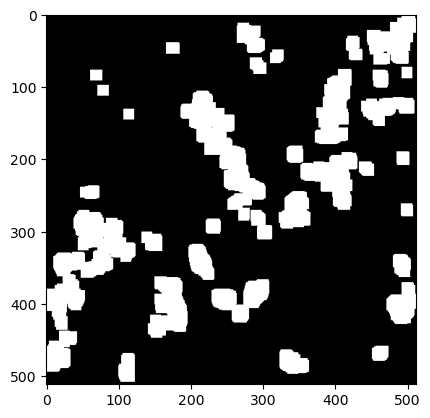

In [12]:
tile_root = Path('../tile_data')
feature_root = Path('../feature_data')
cluster_root = Path('../cluster_data')
patient_id = ['TCGA-2F-A9KR-01']
for patient in patient_id:
    patient_dir = tile_root/patient
    save_name = f'{patient}_clustering_results.npy'
    tiles = [x for x in patient_dir.iterdir() if x.is_file()]
    tiles.sort()
    tile_index = []
    for i in range(len(tiles)):
        num = int(str(tiles[i]).split('/')[-1].split('.')[0].split('_')[-1])
        tile_index.append(num)
    if (8597 in tile_index):
        print("Error")
        break
    tile_index = np.asarray(tile_index)
    cluster_one_patient_2_cluster(patient, tiles, tile_index, None)

In [ ]:
print(np.argwhere(np.asarray(stats) > np.min(stats) + 0.5 * (np.max(stats) - np.min(stats))))

In [ ]:
high_perc = np.percentile(stats, 75)
low_perc = np.percentile(stats, 25)

In [ ]:
cluster_high = tile_index[stats >= high_perc]
cluster_low = tile_index[stats < high_perc]

In [ ]:
cluster_high.shape

In [ ]:
im = cv2.imread(str(tiles[311]))
plt.imshow(im)

In [ ]:
# Watershed
sure_bg = cv2.dilate(opening, kernel, iterations=5)
plt.imshow(sure_bg, cmap='gray')

In [ ]:
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
plt.imshow(dist_transform, cmap='gray')

In [ ]:
print(dist_transform.max())

In [ ]:
ret2, sure_fg = cv2.threshold(dist_transform, 0.2*dist_transform.max(), 255, 0)
plt.imshow(sure_fg, cmap='gray')

In [ ]:
sure_fg = np.uint8(sure_fg)
sure_bg = np.uint8(sure_bg)
unknown = cv2.subtract(sure_bg, sure_fg)
plt.imshow(unknown, cmap='gray')

In [ ]:
ret3, markers = cv2.connectedComponents(sure_fg)
# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
# marker = cv2.morphologyEx(marker, cv2.MORPH_OPEN, kernel)
plt.imshow(markers)

In [ ]:
markers += 10
markers[unknown==255] = 0 # unknown should label as 0
plt.imshow(markers, cmap='gray') # background has value of 10, unknown is 0, 

## KNN Attempts

### Use Flattened Image 

In [ ]:
from PIL import Image
from sklearn.cluster import KMeans
example = Path('../tile_data/TCGA-DK-A2I6-01/')
flattened = []
index_list = tile_index
for tile in tiles:
    image = Image.open(tile)
    image2 = image.resize((128, 128))   # for 512x512 patch
    image2 = np.array(image2)[:, :, :3]
    flattened.append(image2.flatten())
#     index_list.append(tile) # name of tile

flattened = np.asarray(flattened)
flattened.shape

In [ ]:

kmeans = KMeans(n_clusters=2, random_state=0).fit(flattened)
cluster1 = tile_index[kmeans.labels_ == 0]
cluster2 = tiles_index[kmeans.labels_ == 1]

print(cluster1.shape)
print(cluster2.shape)

In [ ]:
cluster1[0]

In [ ]:
cluster2[0]

In [ ]:
# Visualization
label_1_img = cv2.cvtColor(cv2.imread(cluster1[2000]), cv2.COLOR_BGR2RGB)
plt.imshow(label_1_img)
plt.show()
label_2_img = cv2.cvtColor(cv2.imread(cluster2[1000]), cv2.COLOR_BGR2RGB)
plt.imshow(label_2_img)
plt.show()

### Use Feature Matrix

In [ ]:
features = np.load('../features/TCGA-DK-A2I6-01.npy', allow_pickle=True)
features.shape

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(features)

In [ ]:
cluster3 = tile_index[kmeans.labels_ == 0]
cluster4 = tile_index[kmeans.labels_ == 1]
cluster3.shape[0] + cluster4.shape[0]

In [ ]:
# Visualization
import matplotlib.pyplot as plt
label_1_img = cv2.cvtColor(cv2.imread(str(cluster1[2000])), cv2.COLOR_BGR2RGB)
plt.imshow(label_1_img)
plt.show()
label_2_img = cv2.cvtColor(cv2.imread(str(cluster2[10])), cv2.COLOR_BGR2RGB)
plt.imshow(label_2_img)
plt.show()

In [ ]:
clustering_results = {'cluster_high': cluster_high,
                      'cluster_low': cluster_low,
                      'cluster1': cluster1,
                      'cluster2': cluster2,
                      'cluster3': cluster3,
                      'cluster4': cluster4
                     }
np.save('clustering_results_all.npy', clustering_results)

### Comparison & Intersections

### Image VS Feature KNN

In [ ]:
label_one_intersect = np.intersect1d(cluster1, cluster3)
print(f"There are {label_one_intersect.shape} in intersection")

In [ ]:
label_two_intersect = np.intersect1d(cluster2, cluster4)
print(f"There are {label_two_intersect.shape} in intersection")

In [ ]:
diff = np.setdiff1d(cluster1, label_one_intersect)
print(f"There are {diff.shape} image only in cluster 1")
diff = np.setdiff1d(cluster3, label_one_intersect)
print(f"There are {diff.shape} image only in cluster 3")

In [ ]:
diff = np.setdiff1d(cluster2, label_two_intersect)
print(f"There are {diff.shape} image only in cluster 2")
diff = np.setdiff1d(cluster4, label_two_intersect)
print(f"There are {diff.shape} image only in cluster 4")

### Projection of results

In [39]:
import json
import openslide
def project_clustering_results(patient_id, slide, cluster0, cluster1, cluster_method, thumbnail, color=(255, 255, 255),
                               on_thumbnail=True):
#     os.makedirs(save_dir, exist_ok=True)
    patch_size = 512  # the size of patches extracted from 20x svs image
    target_mag = 20

    mag = slide['mag']
    w = slide['w']
    h = slide['h']
    extract_patch_size = int(patch_size * mag / target_mag)

    N_patch_row = h // extract_patch_size
    stride = round(float(thumbnail.shape[0]) / N_patch_row)

    color_mask = np.ones(thumbnail.shape, dtype=np.float64) * 50.0 / 255
    for j in range(0, thumbnail.shape[1], stride):
        for i in range(0, thumbnail.shape[0], stride):
            index = (j//stride) * N_patch_row + (i//stride)
            if index in cluster0:
                #print("in cluster 0")
                color_mask[i:i + stride, j:j + stride, :] = np.array(color) * 0.5 / 255
            elif index in cluster1:
                #print("in cluster 1")
                color_mask[i:i + stride, j:j + stride, :] = np.array(color) / 255

    if on_thumbnail:
        thumbnail = thumbnail.astype(np.float64) / 255
        result = thumbnail * color_mask
    else:
        result = color_mask

    io.imsave('../projection2/{:s}_projection_{:s}.png'.format(patient_id, cluster_method), (result*255).astype(np.uint8))

In [40]:
slide_info = {}
with open('../slide_info.json', 'r') as fread:
    slide_info = json.load(fread)
for patient in patient_id:
    thumbnail = io.imread(f'../thumbnail_data/thumbnail_{patient}.png')
    slide = slide_info[patient]
    cluster_results = np.load(f'../cluster_data/{patient}_clustering_results.npy', allow_pickle=True)
    cluster1 = cluster_results.item().get('cluster_high')
    #print(cluster1.shape)
    cluster2 = cluster_results.item().get('cluster_low')
    #print(cluster2.shape)
    project_clustering_results(patient, slide, cluster1, cluster2, "distance_transform", thumbnail)

In [7]:
n = np.load('../cluster_data/TCGA-XF-AAMF-01_clustering_results.npy', allow_pickle=True)

In [41]:
import glob
files = list(glob.glob('../projection/*.png'))
patients = []
for f in files:
    patient = f.split('/')[-1].split('_')[0]
    patients.append(patient)
with open('../all_patients_id.txt', 'w') as fwrite:
    for p in patients:
        fwrite.write(p)
        fwrite.write('\n')
    